In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'socofing:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F38300%2F58521%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240429%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240429T062449Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2e6bc57a9cb42fc762b98d7840e9d45070a23feab388ba93242c55d4a006a6fc28941d1d33a07cfb0deb855ca4dd682794ad1389d13f321a20e5ddcc2afba318ebaca69d47ec71c4e386e97c004c9a650700d0786adeb182dc110b5680f8e0a72782937b4019ba1c7bc2a8f886d9a17102a0d0d513fa89e8469c20ad379568bef3343896dafb0120fc5dcdd528a6aa5601109deb5f84f6cf32584bc7fb84b7cd2f109dfd78e838c78e19e000fe319e9bde6a55d5f8c01a4cc1c60c76e14eeb5c1e18a1080e64775f29938c6bd4cd39b3a0438cae659423354b9e6c0bf92ca011b9ff43c7278d943116c199c3749c04884372f6c1cf61ecb45ecabdaf6836b483'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 878317980 bytes downloaded
Downloaded and uncompressed: socofing
Data source import complete.


# Fingerprint Feature Extraction


### Introduction:

Fingerprint biometrics involve: Image Acquisition, Image Enhancing, Feature extraction and matching with template. Since the dataset has unique fingerprints I will implement feature extraction and different techniques for enhancing images such as Edge detection, adaptive thresholding. Feature extraction constitutes of Ridge detection (level 1 feature) and Minutiae extraction (level 3 feature) to generate a template after whicha query image is matched using the metric ROC AUC curve.


### Dependencies and Data

In [2]:
import numpy as np
import glob
import random
import imageio
import PIL, cv2
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from skimage.morphology import convex_hull_image, erosion
from skimage.morphology import square
import matplotlib.image as mpimg
import skimage
import math
from scipy.ndimage.filters import convolve
from PIL import Image,ImageFilter
from skimage.feature import hessian_matrix, hessian_matrix_eigvals

<ipython-input-2-ca8cb3823380>:14: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve


In [3]:
# KAGGLE FINGERPRINT DATA

DATA_DIR = "../input/socofing/SOCOFing/Real/"
list_dirs = list(glob.glob(DATA_DIR+"*.BMP"))
num_images = len(list_dirs)

### Displaying random images from data

<ipython-input-4-48ff595138a6>:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image1 = imageio.imread(display_list[0])
<ipython-input-4-48ff595138a6>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image2 = imageio.imread(display_list[1])
<ipython-input-4-48ff595138a6>:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image3 = imageio.imread(display_list[2])


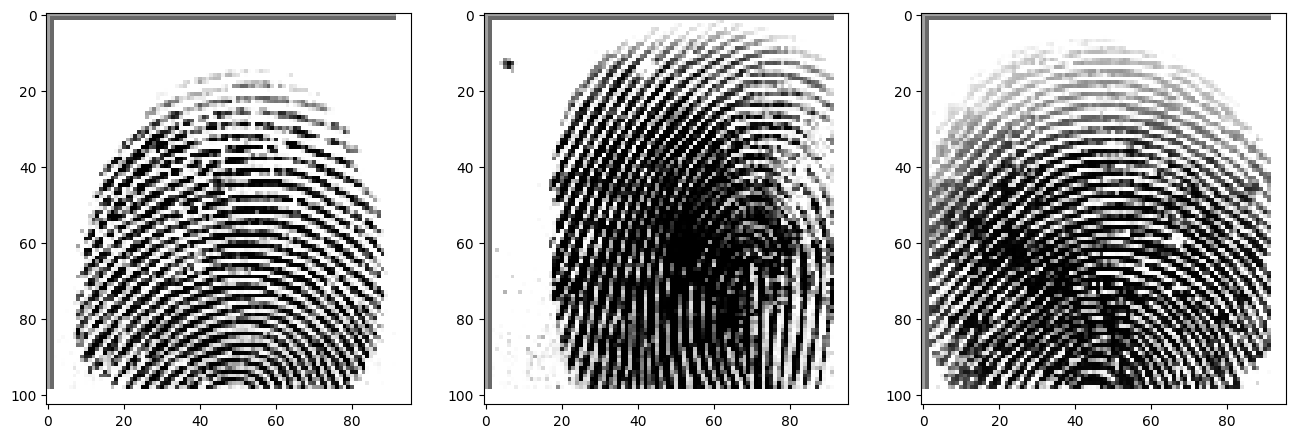

In [4]:
random.seed(42)

r = random.randint(0,num_images)
display_list = list_dirs[r:r+3]

image1 = imageio.imread(display_list[0])
image2 = imageio.imread(display_list[1])
image3 = imageio.imread(display_list[2])

fig, axes = plt.subplots(1,3,figsize = (16,16));
axes[0].imshow(image1);
axes[1].imshow(image2);
axes[2].imshow(image3);

### Image Transforms

1. Image Smoothening
2. Thresholding
3. Edge Detection

Image enhancement and preprocessing techniques such as smoothing, thresholding and edge detection are used to make features more prominent in data for extraction to be more accurate.

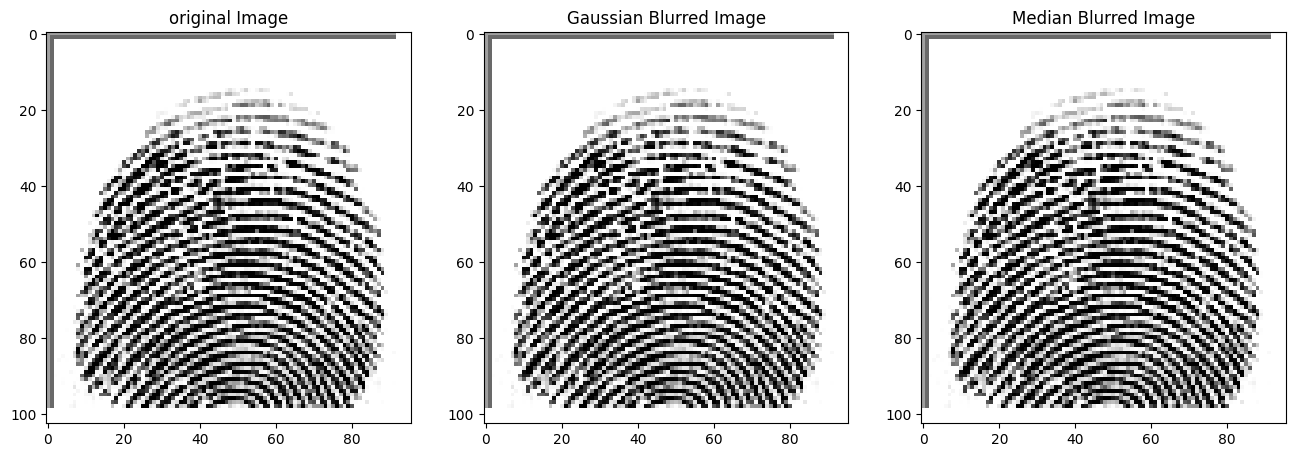

In [5]:
gauss_blur = cv2.GaussianBlur(image1,(1,1),0)
median_blur = cv2.medianBlur(image1,1)

fig, axes = plt.subplots(1,3,figsize = (16,16));
axes[0].set_title("original Image");
axes[0].imshow(image1);
axes[1].set_title("Gaussian Blurred Image");
axes[1].imshow(gauss_blur);
axes[2].set_title("Median Blurred Image");
axes[2].imshow(median_blur);

#### Histograms

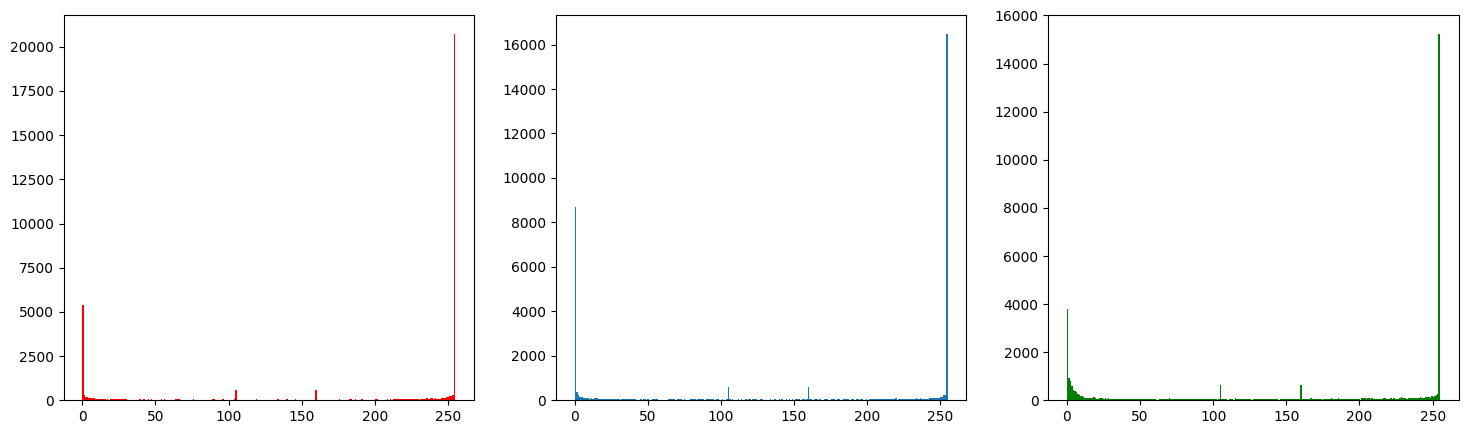

In [6]:
fig, axes = plt.subplots(1,3,figsize = (18,5))
axes[0].hist(image1.ravel(), bins=256, color ="r");
axes[1].hist(image2.ravel(), bins=256);
axes[2].hist(image3.ravel(), bins=256, color ="g");

#### Data seems to be almost binary - implementing mean and adaptive thresholding

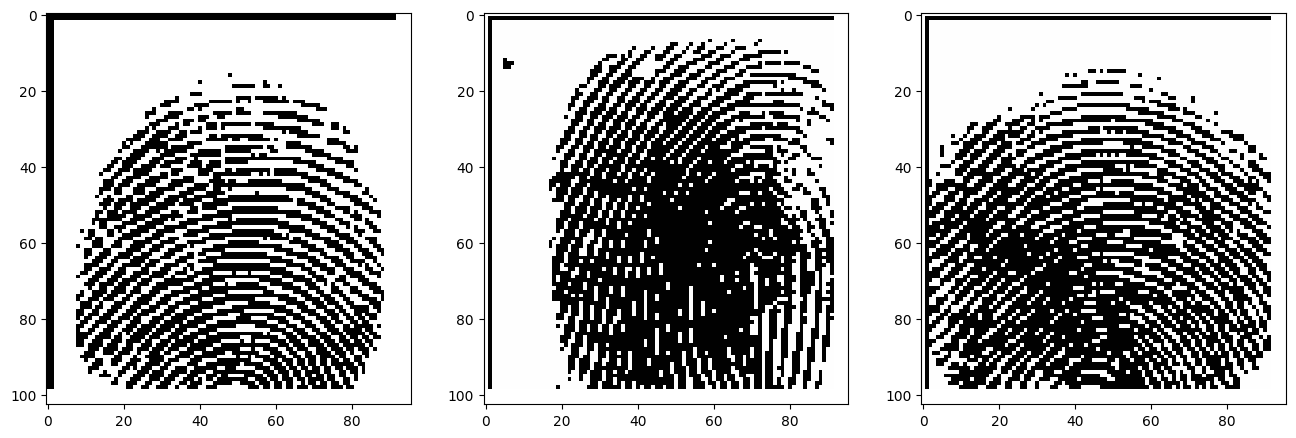

In [7]:
# mean thresholding - gives bad results
THRESHOLD1 = image1.mean()
THRESHOLD2 = image2.mean()
THRESHOLD3 = image3.mean()

image1 = np.array(image1 > THRESHOLD1).astype(int) * 255
image2 = np.array(image2 > THRESHOLD2).astype(int) * 254
image3 = np.array(image3 > THRESHOLD3).astype(int) * 254

fig, axes = plt.subplots(1,3,figsize = (16,16));
axes[0].imshow(image1);
axes[1].imshow(image2);
axes[2].imshow(image3);

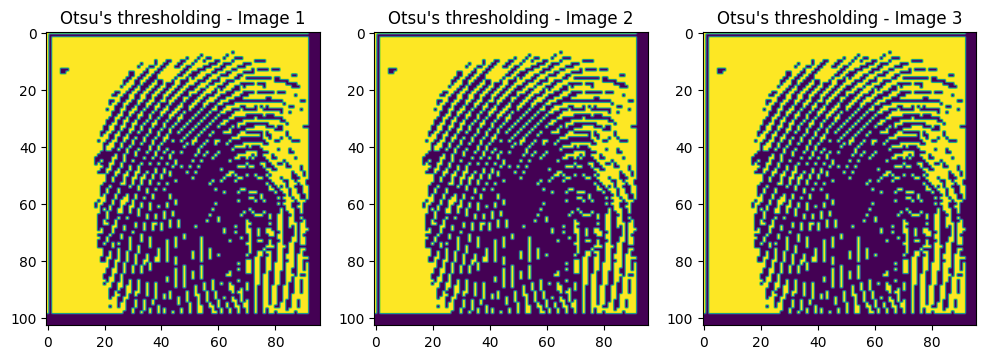

In [8]:
# Adaptive thresholding from OpenCV library - better than Mean Thresholding

img1 = cv2.imread(display_list[0],0)
img2 = cv2.imread(display_list[1],0)
img3 = cv2.imread(display_list[2],0)

# Otsu's thresholding
ret1,th1 = cv2.threshold(img1,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
ret2,th2 = cv2.threshold(img2,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
ret3,th3 = cv2.threshold(img3,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

fig, axes = plt.subplots(1,3,figsize = (12,12));
axes[0].set_title("Otsu's thresholding - Image 1");
axes[0].imshow(th2);
axes[1].set_title("Otsu's thresholding - Image 2");
axes[1].imshow(th2);
axes[2].set_title("Otsu's thresholding - Image 3");
axes[2].imshow(th2);

### Edge detection:

In [9]:
# convert to grayscale
img_name = display_list[0]
gray_img_array = np.array(Image.open(img_name).convert('P'))

Robert, Sobel, Prewitt Filters

In [10]:
vertical_robert_filter = np.array([[1,0],[0,-1]])
horizontal_robert_filter = np.array([[0,1],[-1,0]])

vertical_sobel_filter = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
horizontal_sobel_filter = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])

vertical_prewitt_filter = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
horizontal_prewitt_filter = np.array([[-1,-1,-1],[0,0,0],[1,1,1]])

print("vertical robert filter\n",vertical_robert_filter )
print("horizontal robert filter\n",horizontal_robert_filter)
print("vertical sobel filter: \n", vertical_sobel_filter)
print("horizontal sobel filter: \n", horizontal_sobel_filter)

print("vertical prewitt filter: \n", vertical_prewitt_filter)
print("horizontal prewitt filter: \n", horizontal_prewitt_filter)

vertical robert filter
 [[ 1  0]
 [ 0 -1]]
horizontal robert filter
 [[ 0  1]
 [-1  0]]
vertical sobel filter: 
 [[-1  0  1]
 [-2  0  2]
 [-1  0  1]]
horizontal sobel filter: 
 [[-1 -2 -1]
 [ 0  0  0]
 [ 1  2  1]]
vertical prewitt filter: 
 [[-1  0  1]
 [-1  0  1]
 [-1  0  1]]
horizontal prewitt filter: 
 [[-1 -1 -1]
 [ 0  0  0]
 [ 1  1  1]]


In [11]:
# implementing:
gray_img = Image.fromarray(gray_img_array)

convolved_img1 = convolve(gray_img,vertical_robert_filter)
convolved_img1 = convolve(convolved_img1,horizontal_robert_filter)

convolved_img2 = convolve(gray_img,vertical_sobel_filter)
convolved_img2 = convolve(convolved_img2,horizontal_sobel_filter)

convolved_img3 =  convolve(gray_img,vertical_prewitt_filter )
convolved_img3 =  convolve(gray_img,horizontal_prewitt_filter )

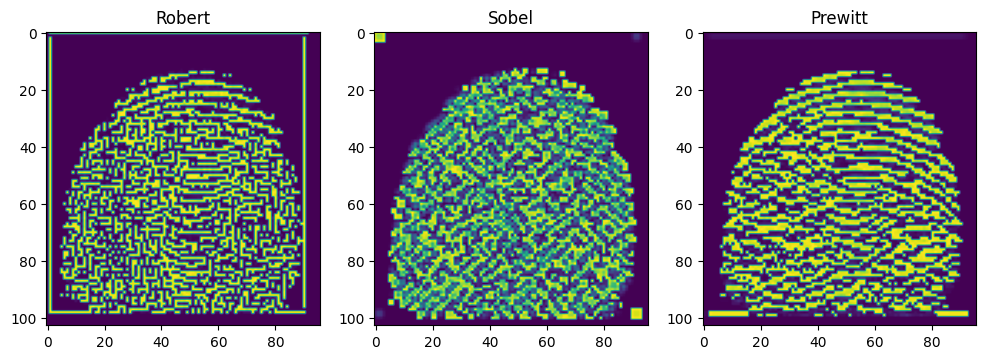

In [12]:
fig, axes = plt.subplots(1,3,figsize = (12,12));
axes[0].set_title("Robert");
axes[0].imshow(convolved_img1);
axes[1].set_title("Sobel");
axes[1].imshow(convolved_img2);
axes[2].set_title("Prewitt");
axes[2].imshow(convolved_img3);

### Ridge Detection

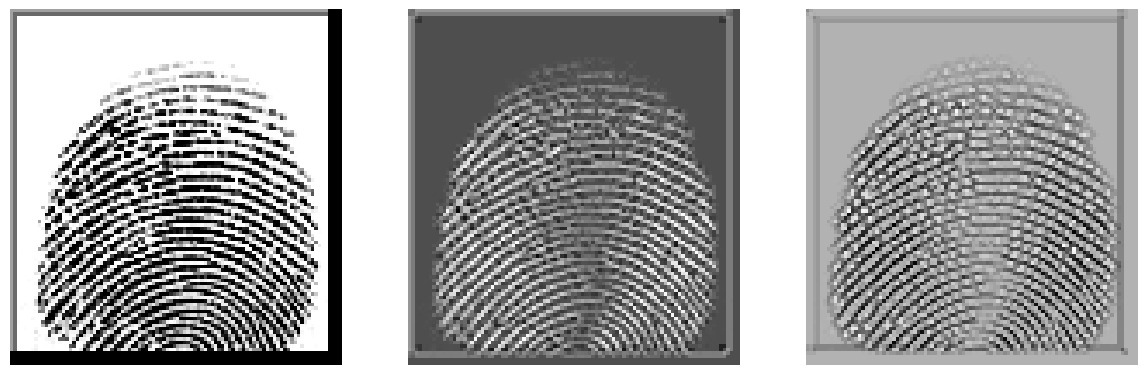

In [13]:
src_path = img_name

def detect_ridges(gray, sigma= 0.1):
    H_elems = hessian_matrix(gray, sigma=sigma, order='rc')
    maxima_ridges, minima_ridges = hessian_matrix_eigvals(H_elems)
    return maxima_ridges, minima_ridges

def plot_images(*images):
    images = list(images)
    n = len(images)
    fig, ax = plt.subplots(ncols=n, sharey=True, figsize = (12,12))
    for i, img in enumerate(images):
        ax[i].imshow(img, cmap='gray')
        ax[i].axis('off')
    plt.subplots_adjust(left=0.03, bottom=0.03, right=0.97, top=0.97)
    plt.show()

img = cv2.imread(src_path, 0) # 0 imports a grayscale
if img is None:
    raise(ValueError(f"Image didn\'t load. Check that '{src_path}' exists."))

a, b = detect_ridges(img, sigma=0.15)

plot_images(img, a, b)

### Termination and Bifurcation detection and Minutiae Extraction

The given code extracts features like Termination, Bifurcation and Minutiae from finger prints, the output is shown below the code:


In [14]:
def getTerminationBifurcation(img, mask):
    img = img == 255;
    (rows, cols) = img.shape;
    minutiaeTerm = np.zeros(img.shape);
    minutiaeBif = np.zeros(img.shape);

    for i in range(1,rows-1):
        for j in range(1,cols-1):
            if(img[i][j] == 1):
                block = img[i-1:i+2,j-1:j+2];
                block_val = np.sum(block);
                if(block_val == 2):
                    minutiaeTerm[i,j] = 1;
                elif(block_val == 4):
                    minutiaeBif[i,j] = 1;

    mask = convex_hull_image(mask>0)
    mask = erosion(mask, square(5))
    minutiaeTerm = np.uint8(mask)*minutiaeTerm
    return(minutiaeTerm, minutiaeBif)

In [15]:
class MinutiaeFeature(object):
    def __init__(self, locX, locY, Orientation, Type):
        self.locX = locX;
        self.locY = locY;
        self.Orientation = Orientation;
        self.Type = Type;

def computeAngle(block, minutiaeType):
    angle = 0
    (blkRows, blkCols) = np.shape(block);
    CenterX, CenterY = (blkRows-1)/2, (blkCols-1)/2
    if(minutiaeType.lower() == 'termination'):
        sumVal = 0;
        for i in range(blkRows):
            for j in range(blkCols):
                if((i == 0 or i == blkRows-1 or j == 0 or j == blkCols-1) and block[i][j] != 0):
                    angle = -math.degrees(math.atan2(i-CenterY, j-CenterX))
                    sumVal += 1
                    if(sumVal > 1):
                        angle = float('nan');
        return(angle)
    elif(minutiaeType.lower() == 'bifurcation'):
        (blkRows, blkCols) = np.shape(block);
        CenterX, CenterY = (blkRows - 1) / 2, (blkCols - 1) / 2
        angle = []
        sumVal = 0;
        for i in range(blkRows):
            for j in range(blkCols):
                if ((i == 0 or i == blkRows - 1 or j == 0 or j == blkCols - 1) and block[i][j] != 0):
                    angle.append(-math.degrees(math.atan2(i - CenterY, j - CenterX)))
                    sumVal += 1
        if(sumVal != 3):
            angle = float('nan')
        return(angle)


def extractMinutiaeFeatures(skel, minutiaeTerm, minutiaeBif):
    FeaturesTerm = []

    minutiaeTerm = skimage.measure.label(minutiaeTerm, connectivity=2);
    RP = skimage.measure.regionprops(minutiaeTerm)

    WindowSize = 2
    FeaturesTerm = []
    for i in RP:
        (row, col) = np.int16(np.round(i['Centroid']))
        block = skel[row-WindowSize:row+WindowSize+1, col-WindowSize:col+WindowSize+1]
        angle = computeAngle(block, 'Termination')
        FeaturesTerm.append(MinutiaeFeature(row, col, angle, 'Termination'))

    FeaturesBif = []
    minutiaeBif = skimage.measure.label(minutiaeBif, connectivity=2);
    RP = skimage.measure.regionprops(minutiaeBif)
    WindowSize = 1
    for i in RP:
        (row, col) = np.int16(np.round(i['Centroid']))
        block = skel[row-WindowSize:row+WindowSize+1, col-WindowSize:col+WindowSize+1]
        angle = computeAngle(block, 'Bifurcation')
        FeaturesBif.append(MinutiaeFeature(row, col, angle, 'Bifurcation'))
    return(FeaturesTerm, FeaturesBif)

def ShowResults(skel, TermLabel, BifLabel):
    minutiaeBif = TermLabel * 0;
    minutiaeTerm = BifLabel * 0;

    (rows, cols) = skel.shape
    DispImg = np.zeros((rows, cols, 3), np.uint8)
    DispImg[:, :, 0] = skel;
    DispImg[:, :, 1] = skel;
    DispImg[:, :, 2] = skel;

    RP = skimage.measure.regionprops(BifLabel)
    for idx, i in enumerate(RP):
        (row, col) = np.int16(np.round(i['Centroid']))
        minutiaeBif[row, col] = 1;
        (rr, cc) = skimage.draw.circle_perimeter(row, col, 1);
        skimage.draw.set_color(DispImg, (rr, cc), (255, 0, 0));

    RP = skimage.measure.regionprops(TermLabel)
    for idx, i in enumerate(RP):
        (row, col) = np.int16(np.round(i['Centroid']))
        minutiaeTerm[row, col] = 1;
        (rr, cc) = skimage.draw.circle_perimeter(row, col, 1);
        skimage.draw.set_color(DispImg, (rr, cc), (0, 0, 255));

    plt.figure(figsize=(6,6))
    plt.title("Minutiae extraction results")
    plt.imshow(DispImg)

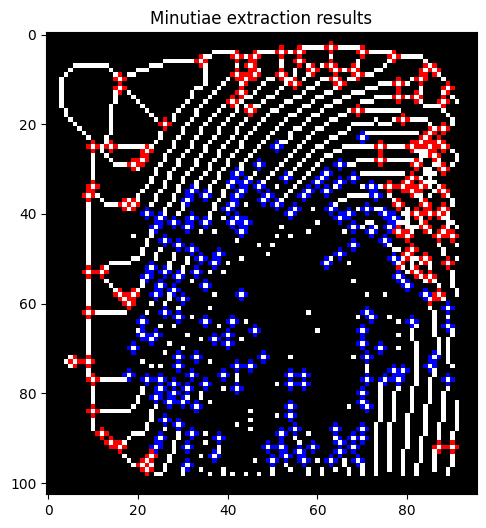

In [16]:

img_name = display_list[1]
img = cv2.imread(img_name,0);
img = np.array(img > THRESHOLD1).astype(int)
skel = skimage.morphology.skeletonize(img)
skel = np.uint8(skel)*255;
mask = img*255;

(minutiaeTerm, minutiaeBif) = getTerminationBifurcation(skel, mask);
FeaturesTerm, FeaturesBif = extractMinutiaeFeatures(skel, minutiaeTerm, minutiaeBif)
BifLabel = skimage.measure.label(minutiaeBif, connectivity=1);
TermLabel = skimage.measure.label(minutiaeTerm, connectivity=1);
ShowResults(skel, TermLabel, BifLabel)